In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Read datasets from CSV

In [2]:
df = pd.read_csv('malicious_dataset.csv') # attacks dataset
normal = pd.read_csv('../mawilab/data/normal_dataset.csv') # normal traffic from mawilab

In [3]:
normal['label'] = "normal" # label column in the normal dataset

## Comparison of datasets
> Check if both datasets have the same columns and calculate the % of attacks vs. normal traffic

In [4]:
if (df.columns == normal.columns).all():
    examples_malicious = df.shape[0]
    examples_legitim = normal.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of malicious and {2:0.2f} legitim packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 296409 with 0.65 of malicious and 0.35 legitim packets


In [5]:
df.head()

frame_info.encap_type                      frame_info.time  \
0                      1  Sep  2, 2020 21:04:37.063530000 -03   
1                      1  Sep  2, 2020 21:04:39.363792000 -03   
2                      1  Aug 27, 2020 21:12:52.279948000 -03   
3                      1  Aug 27, 2020 21:12:56.039540000 -03   
4                      1  Aug 27, 2020 21:12:56.052899000 -03   

   frame_info.time_epoch  frame_info.number  frame_info.len  \
0           1.599091e+09                  1              74   
1           1.599091e+09                  2              74   
2           1.598574e+09                  1              74   
3           1.598574e+09                  2              74   
4           1.598574e+09                  3              74   

   frame_info.cap_len    eth.type  ip.version  ip.hdr_len  ip.tos       ip.id  \
0                  74  0x00000800           4          20     NaN  0x00001b58   
1                  74  0x00000800           4          20     NaN  0x000098f1   
2                  74  0x00000800           4          20     NaN  0x0000832b   
3                  74  0x00000800           4          20     NaN  0x00002fa2   
4                  74  0x00000800           4          20     NaN  0x0000d81c   

     ip.flags  ip.flags.rb  ip.flags.df  ip.flags.mf  ip.frag_offset  ip.ttl  \
0  0x00000000            0            0            0               0      35   
1  0x00000000            0            0            0               0      33   
2  0x00004000            0            1            0               0      34   
3  0x00004000            0            1            0               0      35   
4  0x00004000            0            1            0               0      35   

   ip.proto ip.checksum          ip.src        ip.dst  ip.len  ip.dsfield  \
0         6  0x00003e78  179.241.213.24  172.26.8.200      60  0x00000000   
1         6  0x0000c2de  179.241.213.24  172.26.8.200      60  0x00000000   
2         6  0x00003cd4   187.121.40.97  172.26.8.200      60  0x00000000   
3         6  0x00008f5d   187.121.40.97  172.26.8.200      60  0x00000000   
4         6  0x0000e6e2   187.121.40.97  172.26.8.200      60  0x00000000   

   tcp.srcport  tcp.dstport  tcp.seq  tcp.ack  tcp.len  tcp.hdr_len  \
0         1697         5802        0        0        0           40   
1         1722         5060        0        0        0           40   
2        45868           80        0        0        0           40   
3        45906           80        0        0        0           40   
4        50236           22        0        0        0           40   

    tcp.flags  tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
0  0x00000002              0              1                0               0   
1  0x00000002              0              1                0               0   
2  0x00000002              0              1                0               0   
3  0x00000002              0              1                0               0   
4  0x00000002              0              1                0               0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size tcp.checksum  \
0              0              0              0            64240   0x0000c9e9   
1              0              0              0            64240   0x000090cb   
2              0              0              0            64240   0x0000b178   
3              0              0              0            64240   0x000053fc   
4              0              0              0            64240   0x0000401e   

   tcp.urgent_pointer  tcp.options.mss_val         label  
0                   0               1410.0     nmap_null  
1                   0               1410.0     nmap_null  
2                   0               1440.0  nmap_connect  
3                   0               1440.0  nmap_connect  
4                   0               1440.0  nmap_connect

In [9]:
df.label.value_counts()

zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

---
## Pre-processing
> Necessário conversão dos atributos que são extraídos do `pcap` como hexadecimal
> Preenchido os campos que possuem valores nulos (NaN) por zero

In [10]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df[field] = df[field].apply(lambda x: int(str(x), 16))
    

In [11]:
normal = normal.fillna(0)
for field in fields:
    normal[field] = normal[field].apply(lambda x: int(str(x), 16))

### Criação do dataset com todos os pacotes normais e maliciosos

In [12]:
full_data = pd.concat([normal, df])

### Checando se há pacotes com o campo de protocolo diferente de TCP (valor 6)

In [13]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("Foram encontrados e removidos", wrong_proto,"pacotes do dataset original.")

Foram encontrados e removidos [11708] pacotes do dataset original.


In [14]:
full_data.label.value_counts()

normal           91386
zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

### Atributos não aplicáveis nesse trabalho

> Remoção dos atributos da camada de enlace (link) - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remoção de atributos redudantes ou invariáveis
> - ip.version - trata-se de IPv4
> - ip.proto - o escopo do trabalho restringe-se a TCP
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags

In [15]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True) # 'tcp.flags'

## Análise Exploratória dos Dados

In [16]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284701 entries, 1 to 193314
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           284701 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                284701 non-null  int64  
 3   ip.flags.rb          284701 non-null  float64
 4   ip.flags.df          284701 non-null  float64
 5   ip.flags.mf          284701 non-null  float64
 6   ip.frag_offset       284701 non-null  float64
 7   ip.ttl               284701 non-null  float64
 8   ip.checksum          284701 non-null  int64  
 9   ip.len               284701 non-null  float64
 10  ip.dsfield           284701 non-null  int64  
 11  tcp.srcport          284701 non-null  float64
 12  tcp.dstport          284701 non-null  float64
 13  tcp.seq              284701 non-null  float64
 14  tcp.ack              284701 non-null  float64
 15  tcp.len          

In [17]:
full_data.describe()

ip.hdr_len   ip.tos          ip.id  ip.flags.rb    ip.flags.df  \
count    284701.0  91386.0  284701.000000     284701.0  284701.000000   
mean         20.0      0.0   30469.230737          0.0       0.692512   
std           0.0      0.0   19875.669335          0.0       0.461454   
min          20.0      0.0       0.000000          0.0       0.000000   
25%          20.0      0.0   12754.000000          0.0       0.000000   
50%          20.0      0.0   30003.000000          0.0       1.000000   
75%          20.0      0.0   47899.000000          0.0       1.000000   
max          20.0      0.0   65535.000000          0.0       1.000000   

       ip.flags.mf  ip.frag_offset         ip.ttl    ip.checksum  \
count     284701.0        284701.0  284701.000000  284701.000000   
mean           0.0             0.0      70.303016   33190.062156   
std            0.0             0.0      72.579472   18855.372897   
min            0.0             0.0       1.000000       0.000000   
25%            0.0             0.0      34.000000   16977.000000   
50%            0.0             0.0      35.000000   33315.000000   
75%            0.0             0.0      59.000000   49486.000000   
max            0.0             0.0     254.000000   65534.000000   

              ip.len     ip.dsfield    tcp.srcport    tcp.dstport  \
count  284701.000000  284701.000000  284701.000000  284701.000000   
mean      284.354842       1.914992   33732.450286   14185.343371   
std       519.682808       7.586195   22194.977349   21519.981050   
min        40.000000       0.000000      21.000000       0.000000   
25%        40.000000       0.000000    3196.000000      80.000000   
50%        60.000000       0.000000   40029.000000    1105.000000   
75%        60.000000       0.000000   52480.000000   25971.000000   
max      5981.000000     224.000000   65534.000000   65535.000000   

            tcp.seq       tcp.ack        tcp.len    tcp.hdr_len  \
count  2.847010e+05  2.847010e+05  284701.000000  284701.000000   
mean   1.603251e+07  3.114597e+07     232.669657      31.685186   
std    7.305176e+07  2.108312e+08     520.457774       8.550861   
min    0.000000e+00  0.000000e+00       0.000000      20.000000   
25%    0.000000e+00  0.000000e+00       0.000000      20.000000   
50%    0.000000e+00  0.000000e+00       0.000000      32.000000   
75%    1.000000e+00  1.000000e+00       0.000000      40.000000   
max    4.294967e+09  4.294967e+09    5941.000000      60.000000   

       tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
count  284701.000000  284701.000000    284701.000000   284701.000000   
mean        0.095665       0.545042         0.043607        0.044745   
std         0.294132       0.497968         0.204220        0.206744   
min         0.000000       0.000000         0.000000        0.000000   
25%         0.000000       0.000000         0.000000        0.000000   
50%         0.000000       1.000000         0.000000        0.000000   
75%         0.000000       1.000000         0.000000        0.000000   
max         1.000000       1.000000         1.000000        1.000000   

       tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
count  284701.000000  284701.000000  284701.000000     2.847010e+05   
mean        0.352963       0.021075       0.007352     3.505964e+04   
std         0.477892       0.143634       0.085426     5.801268e+04   
min         0.000000       0.000000       0.000000     0.000000e+00   
25%         0.000000       0.000000       0.000000     5.120000e+02   
50%         0.000000       0.000000       0.000000     6.424000e+04   
75%         1.000000       0.000000       0.000000     6.424000e+04   
max         1.000000       1.000000       1.000000     1.644544e+07   

        tcp.checksum  tcp.urgent_pointer  tcp.options.mss_val  
count  284701.000000       284701.000000        213987.000000  
mean    32762.054246            0.306244           844.639160  
std     19002.930446         

In [18]:
# checar atributos com variância zero, não contribuem com aprendizado
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [19]:
# remove colunas com variância zero
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Análise univariada dos atributos (boxplot)

In [20]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

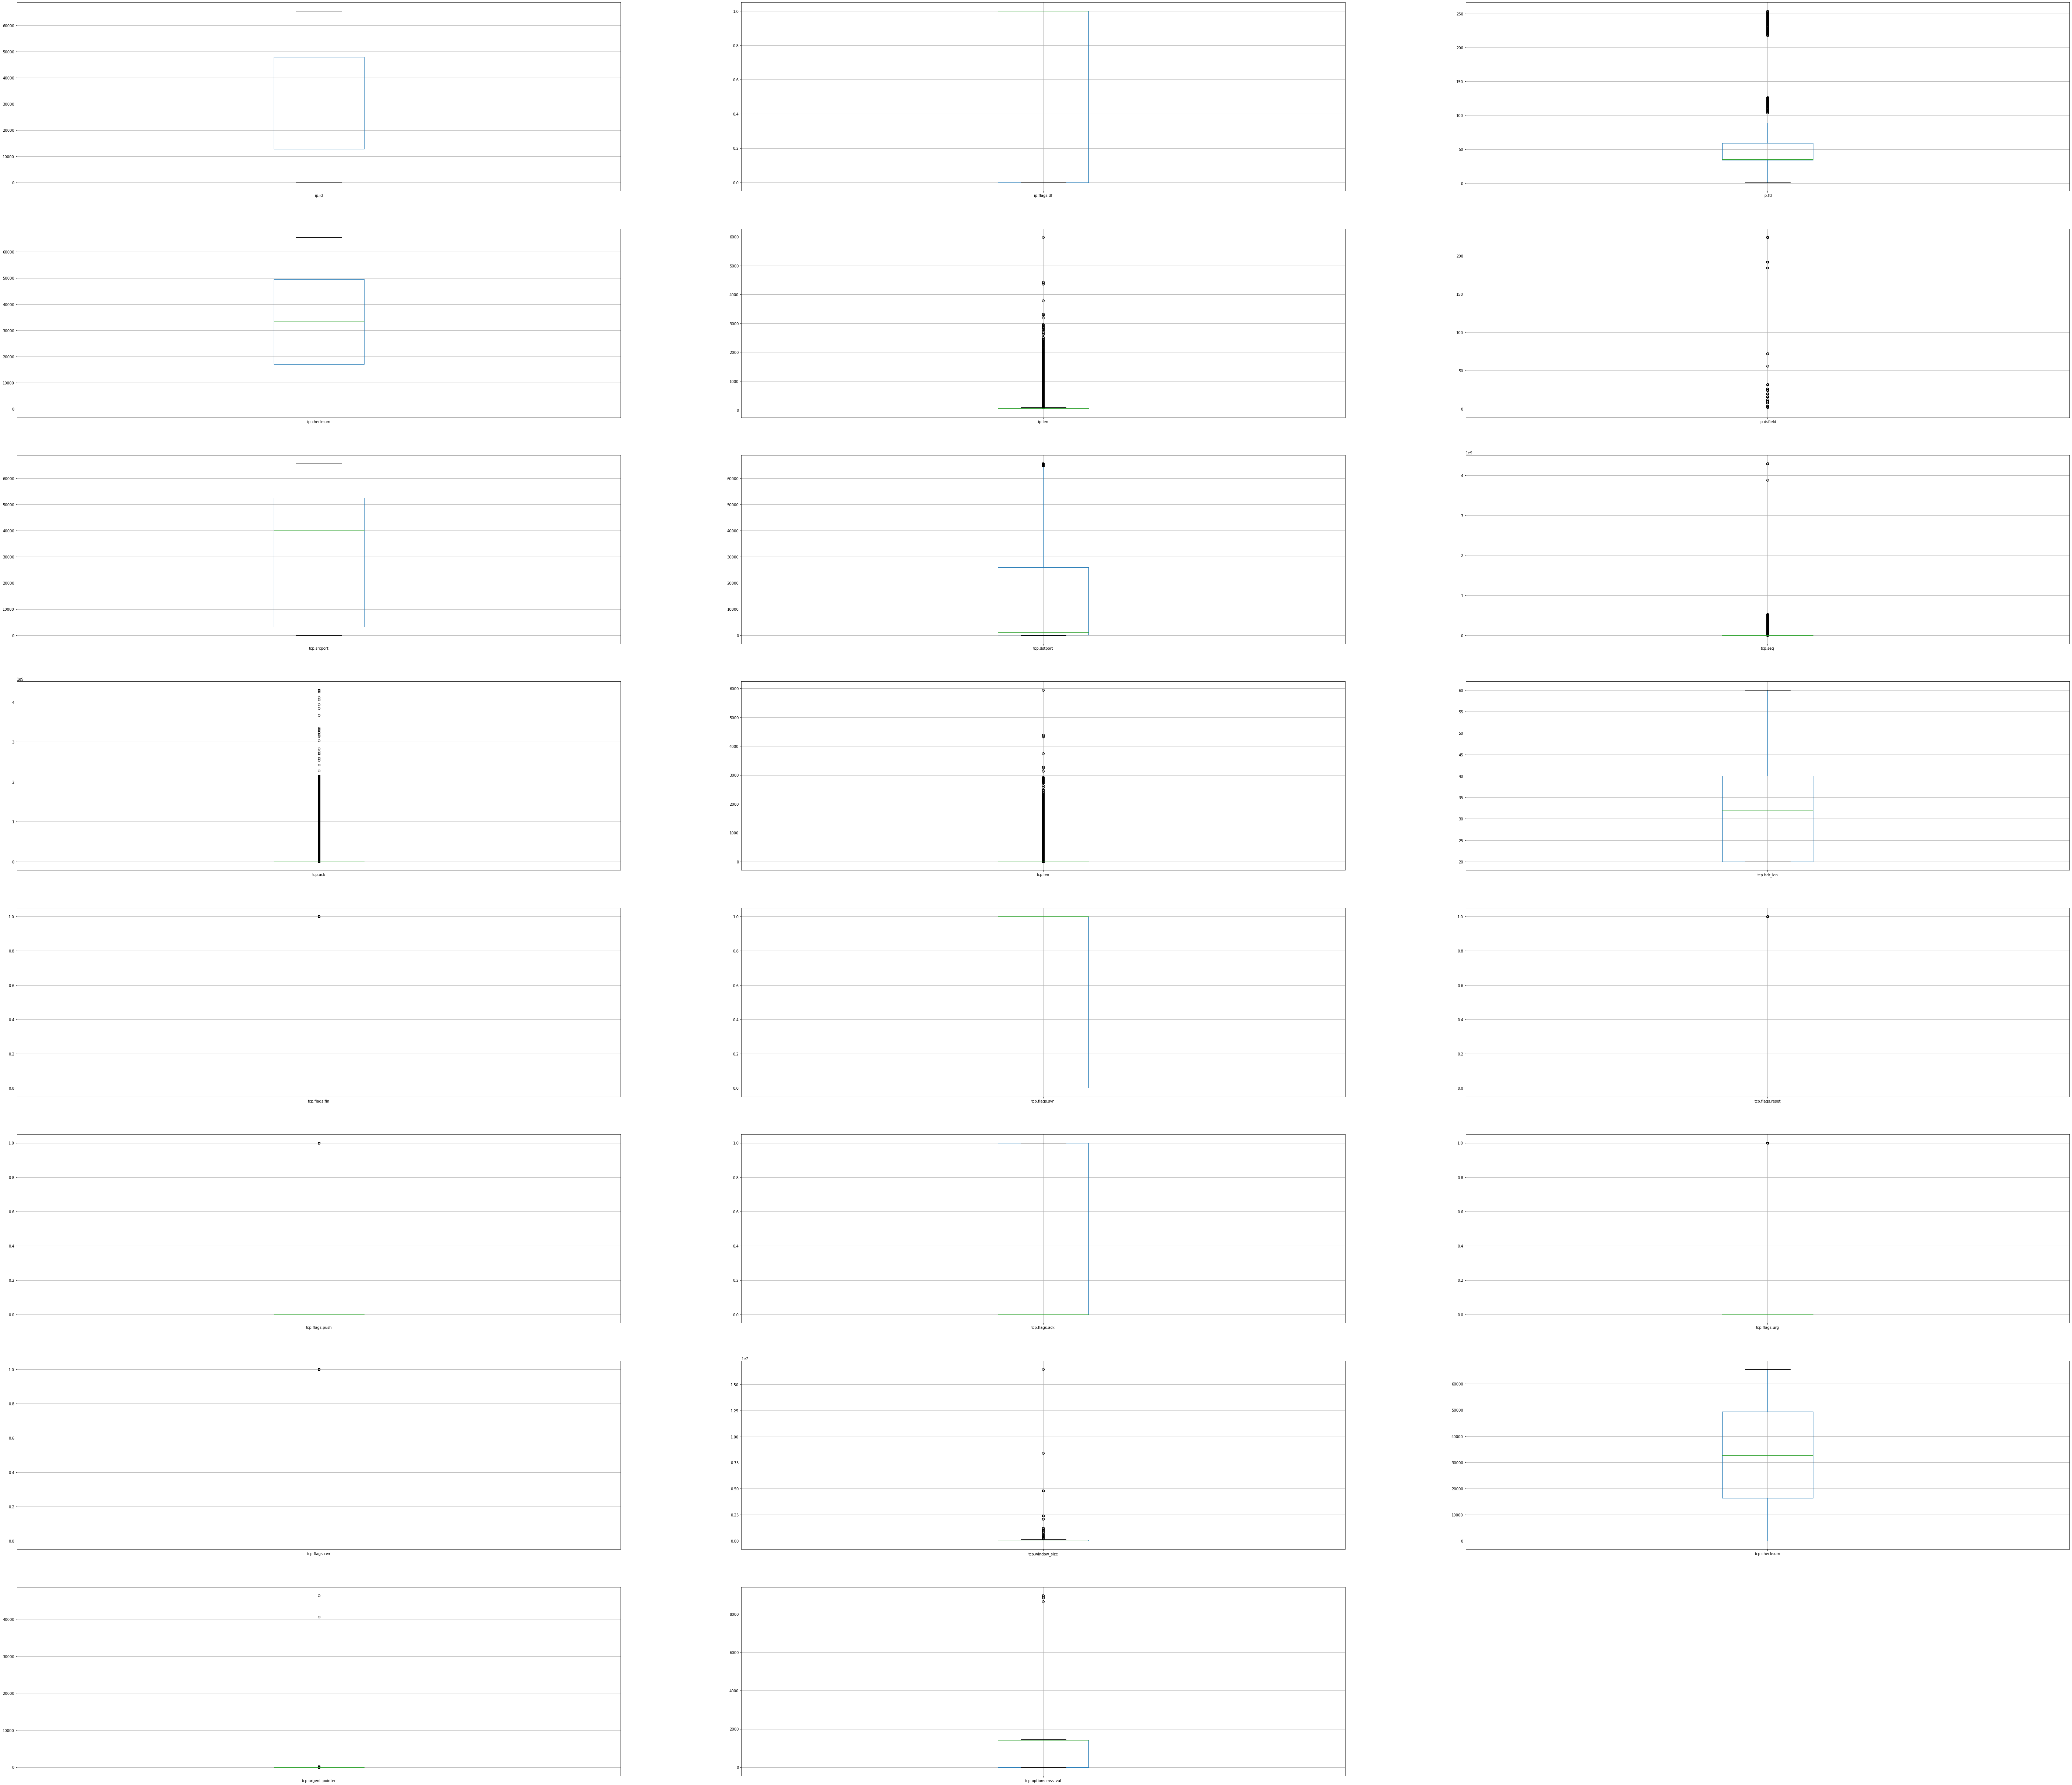

In [21]:
colunas = 3
linhas = int(full_data.shape[1]/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(linhas, colunas, i)
        full_data.boxplot([column]);
        i += 1

### Análise bivariada - Correlação linear (threshold de 0.5)

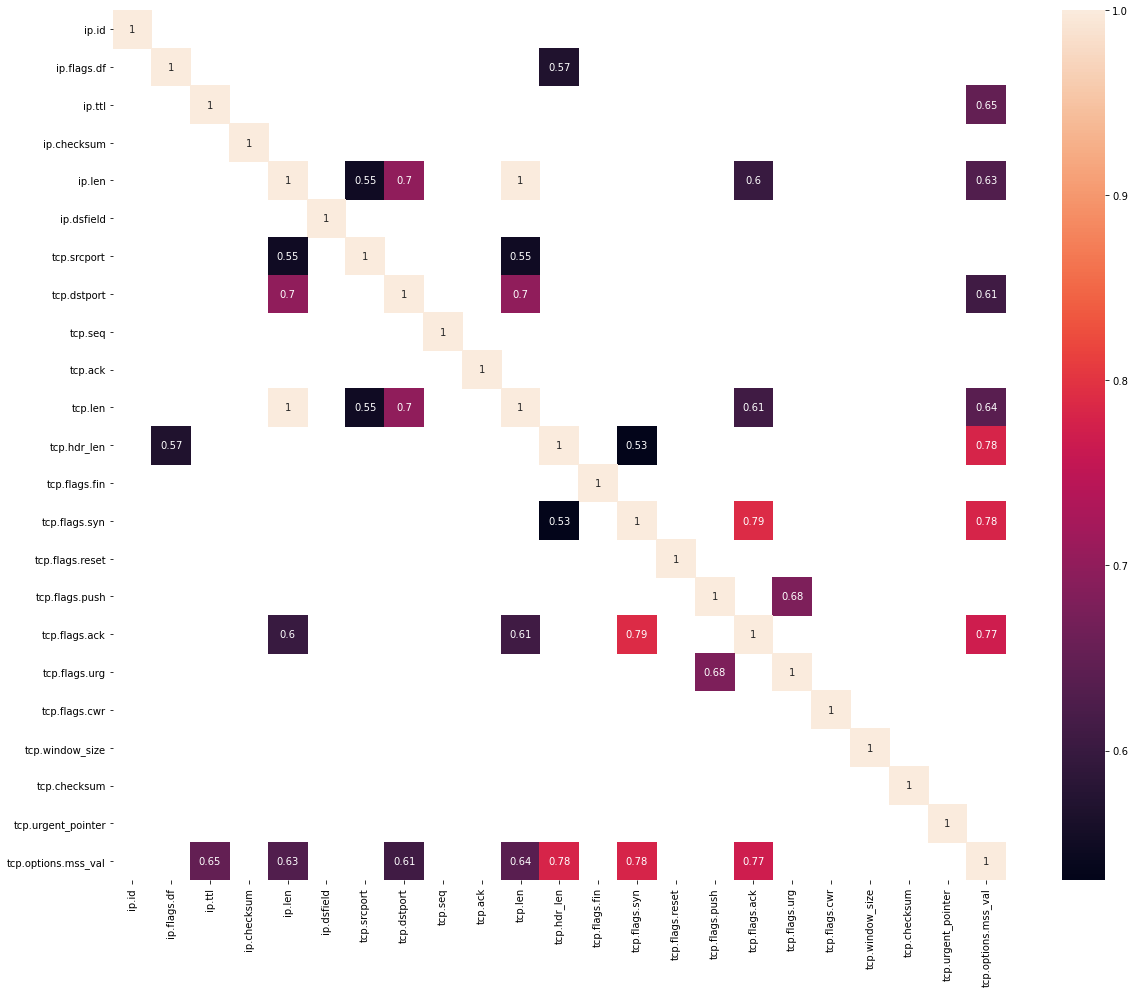

In [22]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Aprendizado de Máquina - Classificação Binária _(scan x normal)_

In [23]:
full_data['label'].value_counts()

normal           91386
zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

In [24]:
full_data.label[full_data.label == "normal"] = 0 # converte os labels de normal por 0
full_data.label[full_data.label != 0] = 1 # converte os labels de scan por 1
full_data['label'].value_counts()

1    193315
0     91386
Name: label, dtype: int64

In [25]:
full_data.shape

(284701, 24)

In [26]:
# ttl tem refletido a arquitetura de obtenção dos pacotes TTL=62 (originalmente 64 menos 2 roteadores)
# "ip.ttl", 
full_data.drop(columns=["ip.checksum", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [27]:
full_data

ip.id  ip.flags.df  ip.ttl  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1       46834          0.0   247.0    40.0           0      0.0         20.0   
3        3793          1.0    56.0   537.0           8    485.0         32.0   
4           0          1.0    59.0    80.0           0      0.0         60.0   
5        8559          1.0    55.0    54.0           0      2.0         32.0   
6       54321          0.0   244.0    40.0           8      0.0         20.0   
...       ...          ...     ...     ...         ...      ...          ...   
193310  55131          1.0    38.0    60.0          32      0.0         40.0   
193311  55695          1.0    38.0    60.0          32      0.0         40.0   
193312  46261          1.0    44.0    60.0          32      0.0         40.0   
193313  29691          1.0    38.0    60.0          32      0.0         40.0   
193314  36311          1.0    38.0    60.0          32      0.0         40.0   

        tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1                 0.0            1.0              0.0             0.0   
3                 0.0            0.0              0.0             1.0   
4                 0.0            0.0              0.0             0.0   
5                 0.0            0.0              0.0             1.0   
6                 0.0            1.0              0.0             0.0   
...               ...            ...              ...             ...   
193310            0.0            1.0              0.0             0.0   
193311            0.0            1.0              0.0             0.0   
193312            0.0            1.0              0.0             0.0   
193313            0.0            1.0              0.0             0.0   
193314            0.0            1.0              0.0             0.0   

        tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1                 0.0            0.0            0.0           1024.0   
3                 1.0            0.0            0.0            252.0   
4                 1.0            0.0            0.0           4677.0   
5                 1.0            0.0            0.0            115.0   
6                 0.0            0.0            0.0          65535.0   
...               ...            ...            ...              ...   
193310            0.0            0.0            0.0          64240.0   
193311            0.0            0.0            0.0          64240.0   
193312            0.0            0.0            0.0          64240.0   
193313            0.0            0.0            0.0          64240.0   
193314            0.0            0.0            0.0          64240.0   

        tcp.urgent_pointer label  
1                      0.0     0  
3                      0.0     0  
4                      0.0     0  
5                      0.0     0  
6                      0.0     0  
...                    ...   ...  
193310                 0.0     1  
193311                 0.0     1  
193312                 0.0     1  
193313                 0.0     1  
193314                 0.0     1  

[284701 rows x 17 columns]

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    #"MLP" : (MLPClassifier(), {
    #    "hidden_layer_sizes" : (10, 10),
    #}),
    #"XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17), {
        "n_estimators" : [10, 50, 100, 200],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(284701, 16) (284701,)


In [29]:
X.head()

ip.id  ip.flags.df  ip.ttl  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1  46834          0.0   247.0    40.0           0      0.0         20.0   
3   3793          1.0    56.0   537.0           8    485.0         32.0   
4      0          1.0    59.0    80.0           0      0.0         60.0   
5   8559          1.0    55.0    54.0           0      2.0         32.0   
6  54321          0.0   244.0    40.0           8      0.0         20.0   

   tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1            0.0            1.0              0.0             0.0   
3            0.0            0.0              0.0             1.0   
4            0.0            0.0              0.0             0.0   
5            0.0            0.0              0.0             1.0   
6            0.0            1.0              0.0             0.0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1            0.0            0.0            0.0           1024.0   
3            1.0            0.0            0.0            252.0   
4            1.0            0.0            0.0           4677.0   
5            1.0            0.0            0.0            115.0   
6            0.0            0.0            0.0          65535.0   

   tcp.urgent_pointer  
1                 0.0  
3                 0.0  
4                 0.0  
5                 0.0  
6                 0.0

In [30]:
X = X.astype(int) 
X.head()

ip.id  ip.flags.df  ip.ttl  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1  46834            0     247      40           0        0           20   
3   3793            1      56     537           8      485           32   
4      0            1      59      80           0        0           60   
5   8559            1      55      54           0        2           32   
6  54321            0     244      40           8        0           20   

   tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1              0              1                0               0   
3              0              0                0               1   
4              0              0                0               0   
5              0              0                0               1   
6              0              1                0               0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1              0              0              0             1024   
3              1              0              0              252   
4              1              0              0             4677   
5              1              0              0              115   
6              0              0              0            65535   

   tcp.urgent_pointer  
1                   0  
3                   0  
4                   0  
5                   0  
6                   0

## Grid Search para os parâmetros da Árvore de Decisão

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB
LR
RF


In [ ]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

## Resultado do Grid Search
> Conjunto de hiper-parâmetros, média e desvio padrão

In [346]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.5159995923854559 0.009914213666751522
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.6963866804003397 0.004119645468092879
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.7160002396035535 0.004824867942080026
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.8117640624351198 0.0021161792932129823
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.9147693542609483 0.0018993250364913962
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.9252880966194653 0.0017612853663203246
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.9391184485384955 0.002487506938279232
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9595397259008583 0.0013536768662537012
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9604775817192337 0.0010563418353984248
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.9609915394083489 0.0015191080570

In [347]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

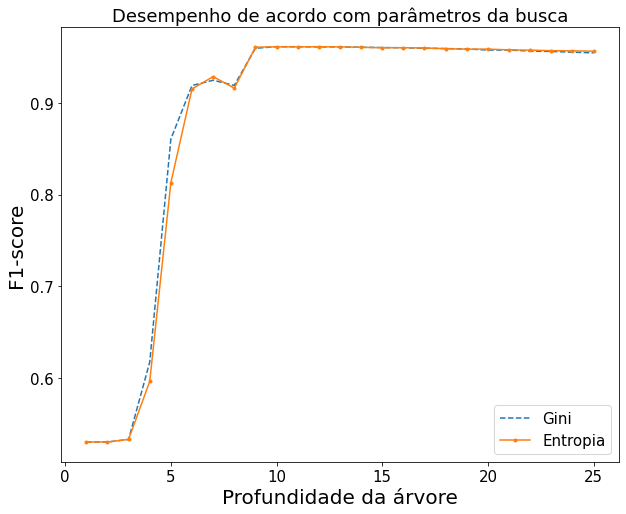

In [348]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})

plt.title('Desempenho de acordo com parâmetros da busca')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Profundidade da árvore', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropia')
plt.legend(loc="lower right");

## Avaliação da importância das features

In [349]:
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced") # {0: 0.01, 1:0.99}

scores = cross_val_score(clf, X, y, cv=kf, scoring='f1') # recall

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.961 (+/- 0.01)


In [350]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=11)

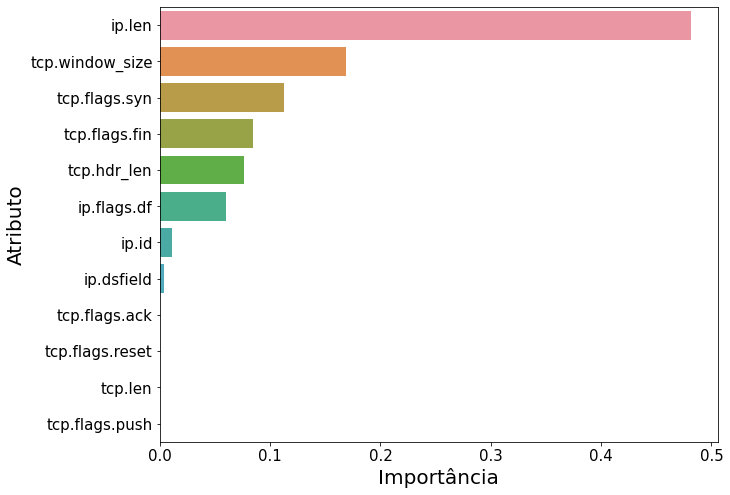

In [351]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

plt.figure(figsize=(10,8))
sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])
plt.xlabel('Importância', fontsize=20)
plt.ylabel('Atributo', fontsize=20);

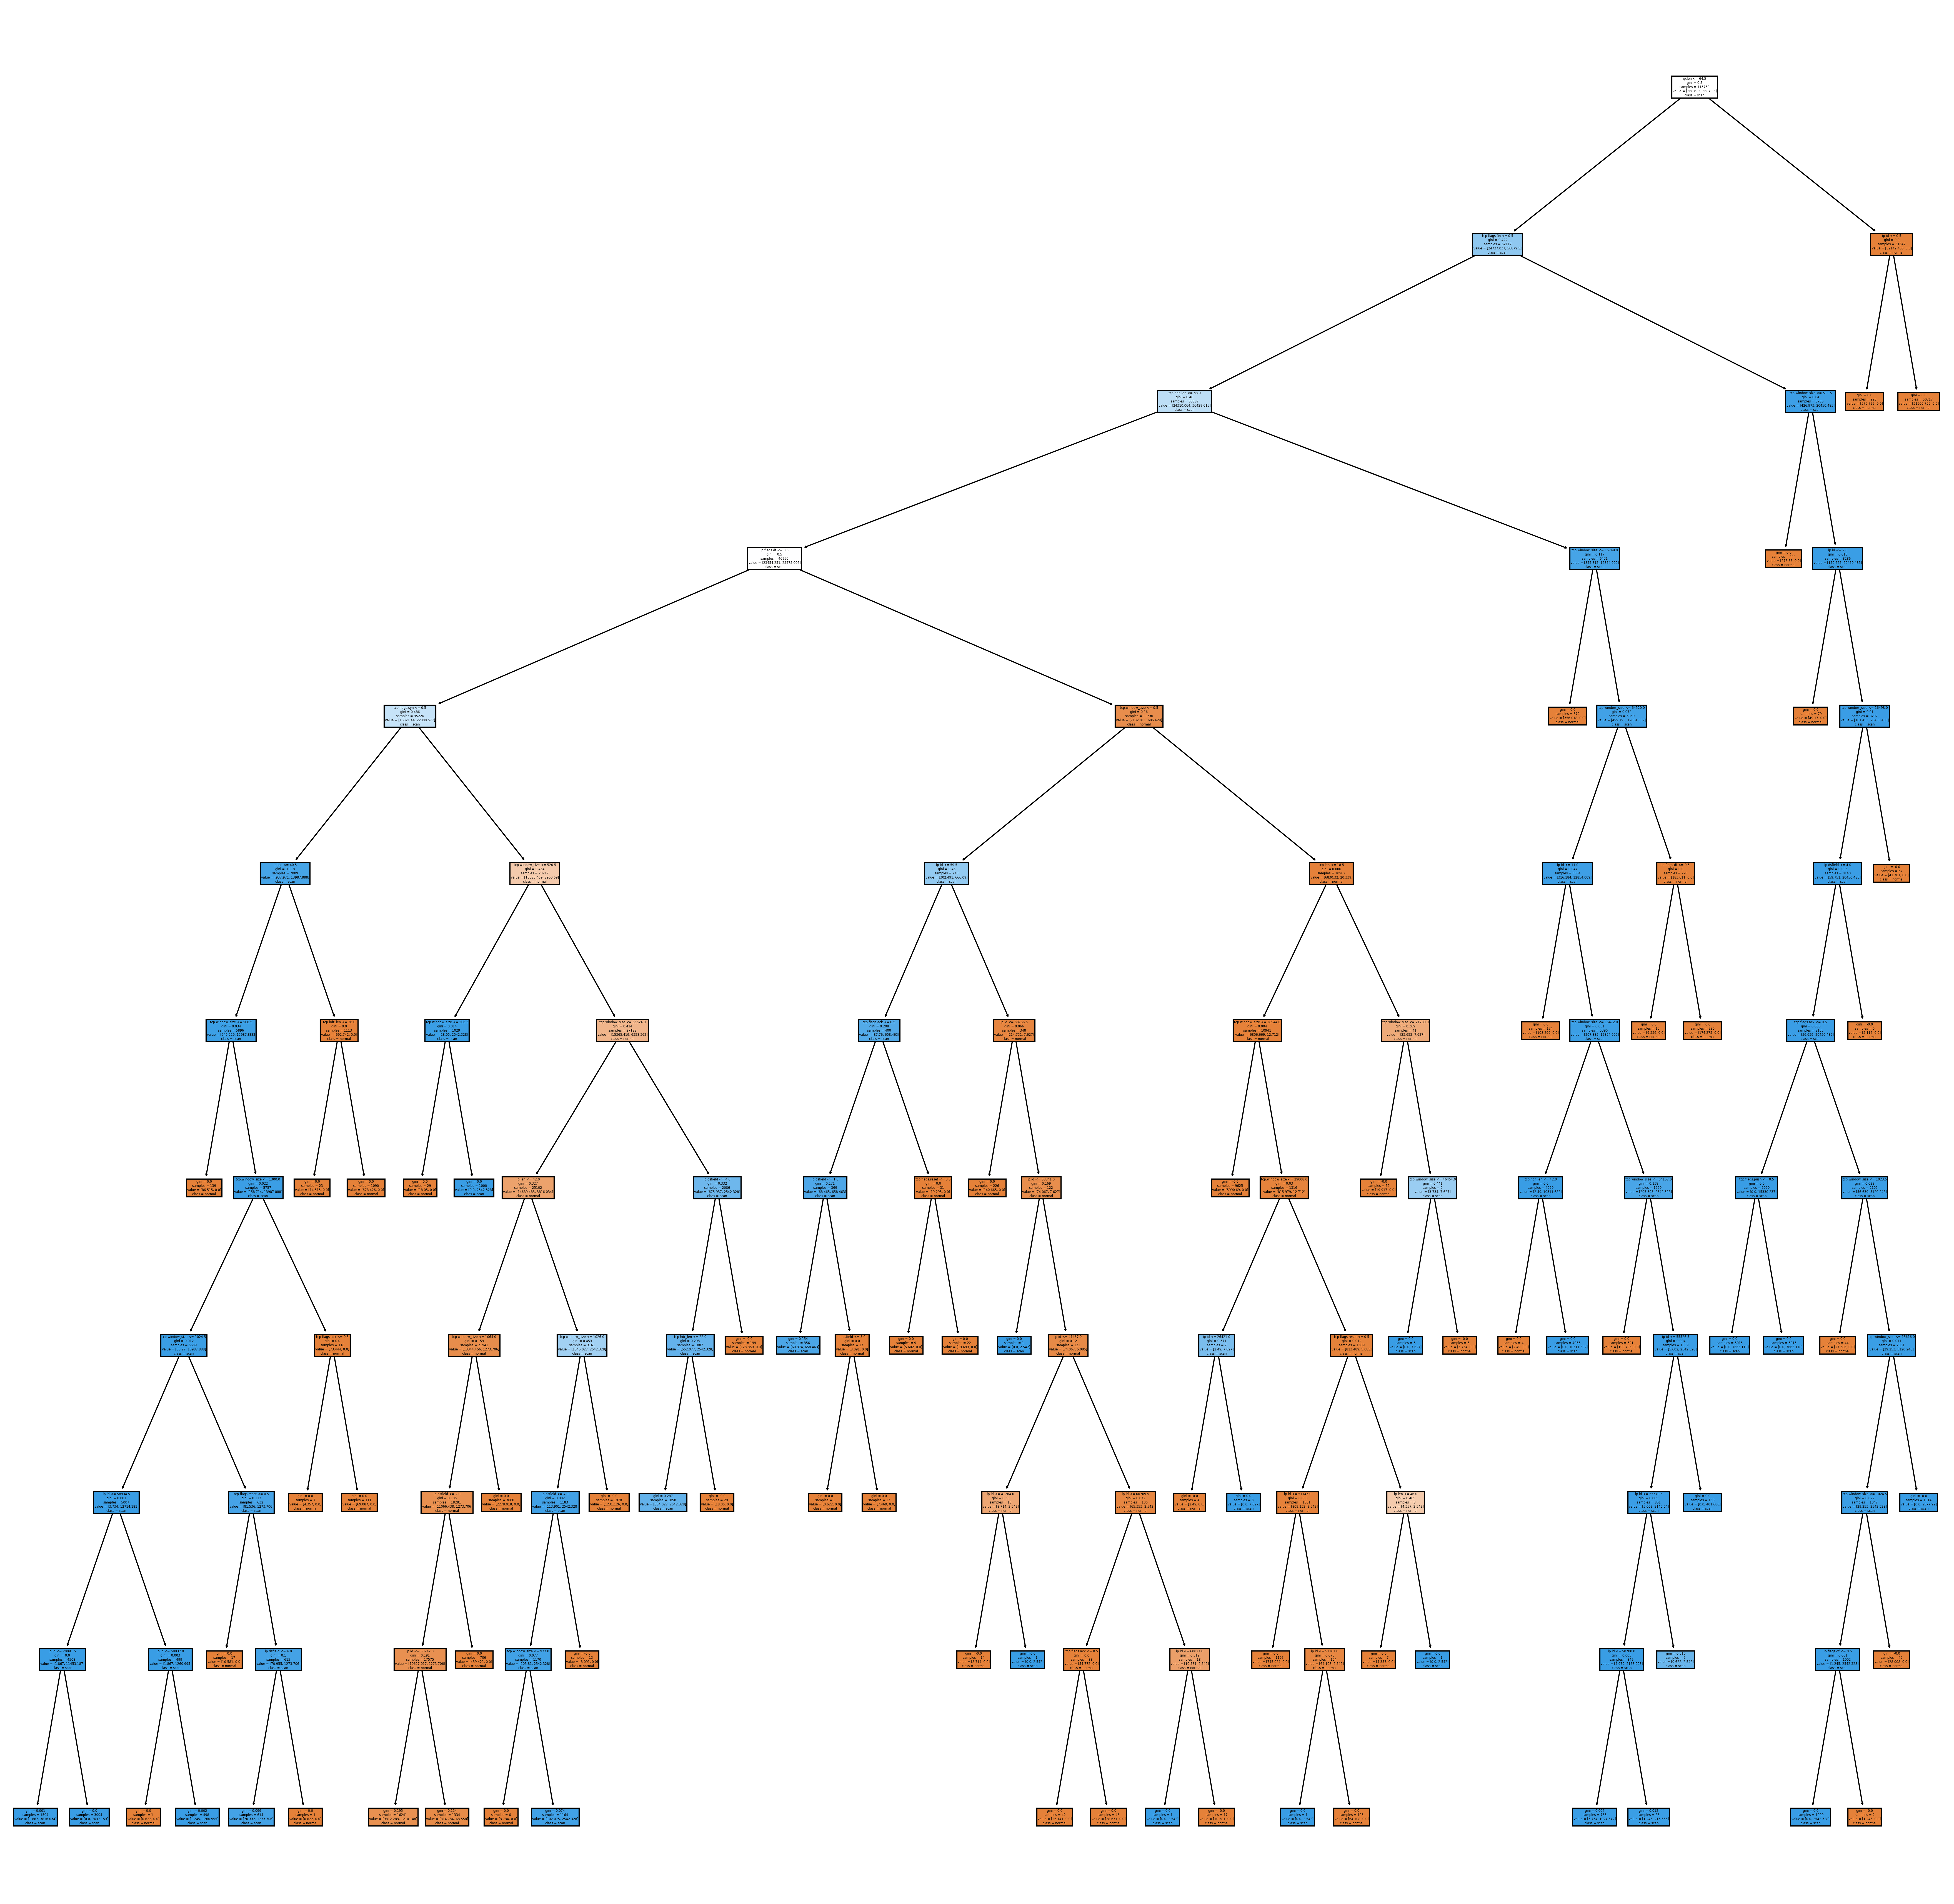

In [352]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

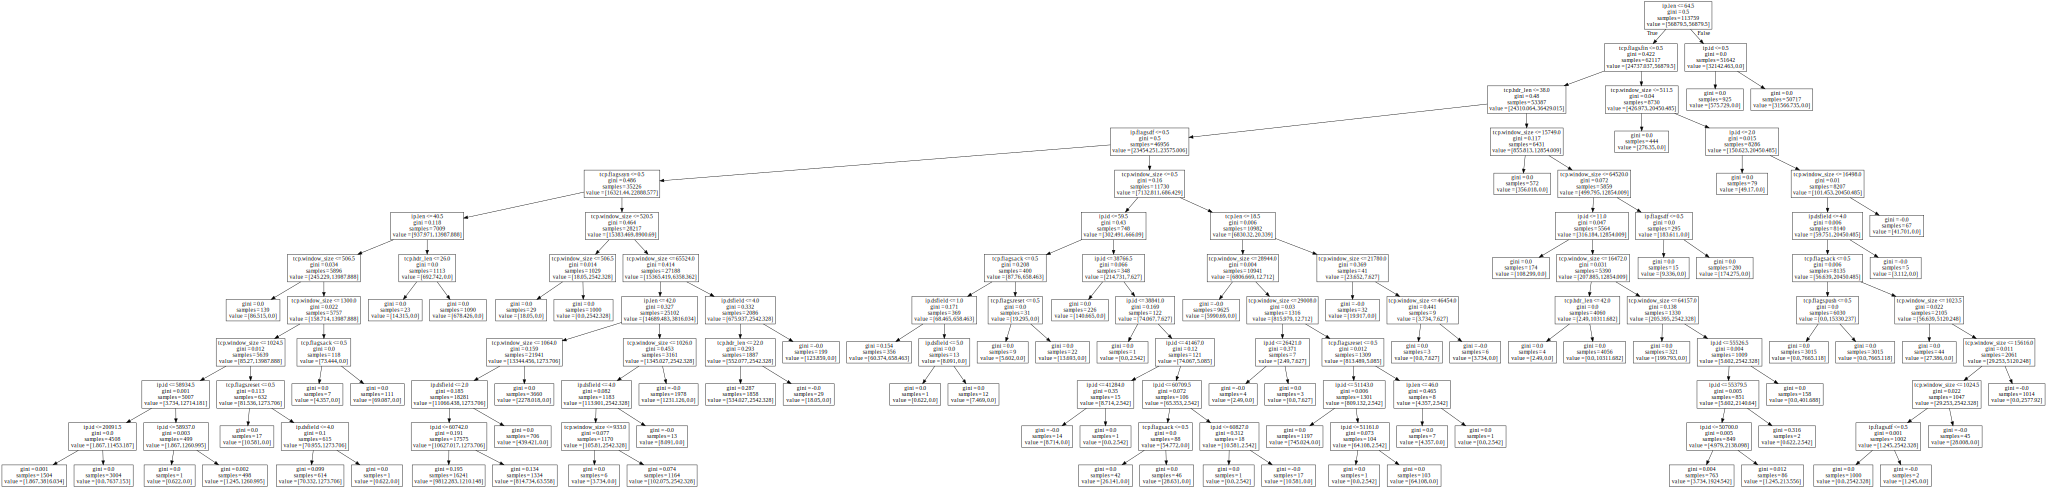

In [353]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

# Geração do modelo de inferência para ser embarcado

In [354]:
#import emlearn
#cmodel = emlearn.convert(clf)
#cmodel.save(file='./data/scan.h');

In [355]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')